### Week 6: Regression Analysis

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>


Citations: <br>
 - Covid-19 case data: https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6 
 - Mobility data: https://www.google.com/covid19/mobility/data_documentation.html
 - Demographics data: https://www.un.org/en/development/desa/population/publications/database/index.asp

### Objective: 
 - predict continous target variables with regression analysis
 - get a sense of how I use ML in my research :)

### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend  #(pip install mlxtend)
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns

# data preprocessing
from sklearn import preprocessing

# model fit
import statsmodels.api as sm

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Step 2: Define working directories

In [2]:
in_dir = '/Users/cilin/Postdoc/teaching/cilin-coursework/data/week06/'
out_dir = '/Users/cilin/Postdoc/teaching/cilin-coursework/data/week06/'

### Step 3: Define classes

### Step 4: Define functions

In [3]:
def model_vars(df, mob_model, adm0_names, dates):
    """ Create Y, X arrays, depending on model specification
    # param df: df
    # param mob_model: list of strings, mobility model of interest
    # param adm0_names: list of strings, adm0_names of interest
    # param dates: list of strings, dates of interest
    # return Y, X np. arrays that will be used in the regression model
    """
    ## keep observations only if adm0_name is in training date
    df = df[df.adm0_name.isin(adm0_names)]
    
    ## keep observations only if date is in data_period
    df = df[df.date.isin(dates)]
    
    ## keep if country is not 'Antigua and Barbuda'
    df = df[~df.adm0_name.isin(['Antigua and Barbuda'])]
    
    ## create dependent variable
    y = df['D_ln_cum_cases']
    
    ## create FE (dummy) variables
    # for adm0_name
    adm0_name_d = pd.get_dummies(df['adm0_name'], drop_first = False)  # don't drop first adm0_name because no intercept is added
    
    # for day of week
    days = ['1', '2', '3', '4', '5', '6']   # dropped the first day == "0"
    doy_of_w_d = pd.get_dummies(df['day_of_week'], prefix='', prefix_sep='', drop_first = True) 
    doy_of_w_d = doy_of_w_d.T.reindex(days).T.fillna(0)

    # join dummies
    dummies = adm0_name_d.join(doy_of_w_d)

    ## create explanatory variables
    if mob_model == "no_mobility":
        X = df[[]]
        
    if mob_model == "mobility":
        X = df[['mob_L1to7', 'mob_L8to14', 'mob_L15to21']]

    ## join explanatory and dummy variables
    X = X.join(dummies)
    print("Shape of X", X.shape)

    return X, y, df

In [4]:
def pct_error_plot(df, plot_type):
    """ Plot relationship between (forecast length, training length) and pct_error
    # param df: df, (test data) predictions
    # param plot_type: string, e.g., 'violin', 'box'
    # return None
    """
    
    # add length of forecast (in days) variable
    df['pred_day'] = df.groupby(['adm0_name', 'mob_model'], as_index = False)['date'].cumcount()
    df['pred_day'] = df['pred_day'] + 1
    
    # initialize new figure
    sns.set(rc={})
    
    # plot axes
    ax = sns.catplot(x='pred_day', y='pct_error', hue='mob_model', data=df, kind=plot_type, palette='muted', legend=False)
    
    # set figure size
    ax.fig.set_figwidth(10)
    ax.fig.set_figheight(6)

    # set title, axes
    plt.title('Percentage error in predicted number of cases at the country level \n train_length = 20 days', fontsize = 16)
    plt.ylabel('pct_error')
    plt.xlabel('length of forecast (days)')
    ax.set(ylim=(-75, 75))
    
    # add vertical line at y=0
    plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
    
    # set legend
    legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=10, prop={'size': 10})
    #legend.get_title().set_fontsize('10')

### Step 5: Define global variables

In [5]:
train_period = ['4-01', '4-02', '4-03', '4-04', '4-05', 
                '4-06', '4-07', '4-08', '4-09', '4-10',
                '4-11', '4-12', '4-13', '4-14', '4-15',
                '4-16', '4-17', '4-18', '4-19', '4-20']

test_period = ['4-21', '4-22', '4-23', '4-24', '4-25',
               '4-26', '4-27', '4-28', '4-29', '4-30']

---
### Step 6: Read data
---

Today we will be working with the open source Covid-19 case data, Google residential mobility data, and UN demographics data, all available in the citation section above.
    
The data includes information on demographics, number of cumulative cases, and changes in residential mobility compared to a baseline* for 188 countries in the world.

*baseline residential mobility: is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.

I already concatenated these data sources, and I added a few additional variables that will help us run some meaninful analyses. Let's dig into it.

In [6]:
init_df = pd.read_csv(in_dir + 'global_data_mob2.csv', sep=',')
init_df.sort_values(by=['date', 'adm0_name'])

print('Shape of data: ', init_df.shape)
print('Number of counties: ', len(init_df.adm0_name.unique()))
init_df.head(2)

Shape of data:  (19552, 73)
Number of counties:  188


,adm0_name,date,day_of_week,cum_cases,active_cases,SDG_region,subregion,pop_all,pop_age_0-4,pop_age_5-9,...,L17_mob_resid,L18_mob_resid,L19_mob_resid,L20_mob_resid,L21_mob_resid,mob_L1to7,mob_L8to14,mob_L15to21,pre_zeroing,regime_change
0,Afghanistan,2020-02-16,6,0,0,CENTRAL AND SOUTHERN ASIA,Southern Asia,38928341.0,5672509.0,5416223.0,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1,0
1,Afghanistan,2020-02-17,0,0,0,CENTRAL AND SOUTHERN ASIA,Southern Asia,38928341.0,5672509.0,5416223.0,...,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,1,0


The (continous) outcome variable is number of cumulative cases (cum_cases).

There are lots of features to choose from, but today we will focus only on a few of them.

---
### Step 7: Data preprocessing
---

#### Step 7.1 Redefine date and keep only cols of interest

In [7]:
# redefine date (drop year, easier for graph visualizations)
init_df['date'] = init_df.date.astype(str);
init_df['date'] = init_df.date.str.slice(start=6);

# keep only the country name, the outcome and the features of interest
keep_vars = ['adm0_name', 'cum_cases', 'date', 'day_of_week', 'pop_all', 'pop_age_60-100+_%', 'international_migrants (% pop)',
             'mob_resid', 'mob_L1to7', 'mob_L8to14', 'mob_L15to21']

df = init_df[keep_vars]

print('Shape of data: ', df.shape)
df.head(20)

Shape of data:  (19552, 11)


,adm0_name,cum_cases,date,day_of_week,pop_all,pop_age_60-100+_%,international_migrants (% pop),mob_resid,mob_L1to7,mob_L8to14,mob_L15to21
0,Afghanistan,0,2-16,6,38928341.0,0.042228,0.003847,0.0,5.000000,NaN,NaN
1,Afghanistan,0,2-17,0,38928341.0,0.042228,0.003847,-1.0,2.500000,NaN,NaN
2,Afghanistan,0,2-18,1,38928341.0,0.042228,0.003847,-1.0,1.333333,NaN,NaN
3,Afghanistan,0,2-19,2,38928341.0,0.042228,0.003847,1.0,0.750000,NaN,NaN
4,Afghanistan,0,2-20,3,38928341.0,0.042228,0.003847,1.0,0.800000,NaN,NaN
5,Afghanistan,0,2-21,4,38928341.0,0.042228,0.003847,0.0,0.833333,NaN,NaN
6,Afghanistan,0,2-22,5,38928341.0,0.042228,0.003847,0.0,0.714286,NaN,NaN
7,Afghanistan,0,2-23,6,38928341.0,0.042228,0.003847,1.0,0.000000,5.000000,NaN
8,Afghanistan,1,2-24,0,38928341.0,0.042228,0.003847,0.0,0.142857,2.500000,NaN
9,Afghanistan,1,2-25,1,38928341.0,0.042228,0.003847,0.0,0.285714,1.333333,NaN


#### Step 7.2 Redefine outcome variable

Instead of predicting the number of cumulative cases, we want to predict the growth rate in cumulative cases. The growth rate formula is:

$growth\_rate = \frac{cum\_cases_{t+1} - cum\_cases_{t}}{cum\_cases_{t}} = ln(\frac{cum\_cases_{t+1}}{cum\_cases_{t}}) = ln(cum\_cases_{t+1}) - ln(cum\_cases_{t})$

Bellow we will implement this formula. Let's call the growth rate, 'D_ln_cum_cases'.

In [8]:
# log of cum_cases
df['ln_cum_cases'] = np.log(df.cum_cases)
    
# one period difference of log of cum_cases (remember that we need to do this for each country separately!)
df['D_ln_cum_cases'] = df.groupby(['adm0_name'])['ln_cum_cases'].diff()

print('Shape of data: ', df.shape)
df.head(2)

Shape of data:  (19552, 13)


,adm0_name,cum_cases,date,day_of_week,pop_all,pop_age_60-100+_%,international_migrants (% pop),mob_resid,mob_L1to7,mob_L8to14,mob_L15to21,ln_cum_cases,D_ln_cum_cases
0,Afghanistan,0,2-16,6,38928341.0,0.042228,0.003847,0.0,5.0,NaN,NaN,-inf,NaN
1,Afghanistan,0,2-17,0,38928341.0,0.042228,0.003847,-1.0,2.5,NaN,NaN,-inf,NaN


#### Step 7.3 Drop observations

In [9]:
# drop if cum_cases < 10 
df = df[df.cum_cases >= 10]

# drop if D_ln_cum_cases < 0 or inf/-inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df[(df.D_ln_cum_cases >= 0) | (~df.D_ln_cum_cases.isna())]

# drop if rolling averages of mobility today (mob_resid) are NaN
df = df.dropna(how = 'any', subset=['mob_L1to7', 'mob_L8to14', 'mob_L15to21'])

print('Shape of data: ', df.shape)
df.head(2)

Shape of data:  (9077, 13)


,adm0_name,cum_cases,date,day_of_week,pop_all,pop_age_60-100+_%,international_migrants (% pop),mob_resid,mob_L1to7,mob_L8to14,mob_L15to21,ln_cum_cases,D_ln_cum_cases
27,Afghanistan,11,3-14,5,38928341.0,0.042228,0.003847,0.0,1.428571,0.428571,0.857143,2.397895,0.451985
28,Afghanistan,16,3-15,6,38928341.0,0.042228,0.003847,0.0,1.285714,0.428571,1.000000,2.772589,0.374693


#### Step 7.4: Define X and y

We will start by defining the train and test dates (in MM-DD format). Year = 2020.

Note that this time we are not using scikit's train_test_split() to split the data into training and test. A random assignment wouldn't make sense in this case. Instead we use a user-defined function, model_vars().

We also want to compare two-models: a model that includes the mobility variables as features and a model that does not include them.

Finally, we want to use the same countries in the train and test set. You can train on more countries and do predictions on less, but the code becomes a bit more complicated. Let's keep it simple for the moment.

In [10]:
## X_y for mobility model
print('mobility model')
print('--------------')
X_train, y_train, df_train = model_vars(df, mob_model='mobility', adm0_names=df.adm0_name.unique(), dates=train_period)
X_test, y_test, df_test = model_vars(df, mob_model='mobility', adm0_names=df_train.adm0_name.unique(), dates=test_period)

# just making sure that we have the same countries in train and test sets
print('Set difference: ', np.setdiff1d(df_train.adm0_name.unique(), df_test.adm0_name.unique()), '\n')


## X, y for the no_mobility model
print('no_mobility model')
print('-----------------')
X_train_nmob, y_train_nmob, df_train_nmob = model_vars(df, mob_model='no_mobility', adm0_names=df.adm0_name.unique(), dates=train_period)
X_test_nmob, y_test_nmob, df_test_nmob = model_vars(df, mob_model='no_mobility', adm0_names=df_train_nmob.adm0_name.unique(), dates=test_period)

# just making sure that we have the same countries in train and test sets
print('Set difference: ', np.setdiff1d(df_train_nmob.adm0_name.unique(), df_test_nmob.adm0_name.unique()))

mobility model
--------------
Shape of X (2263, 125)
Shape of X (1160, 125)
Set difference:  [] 

no_mobility model
-----------------
Shape of X (2263, 122)
Shape of X (1160, 122)
Set difference:  []


In [11]:
# visualize X_train
pd.DataFrame(X_train).head(2)

,mob_L1to7,mob_L8to14,mob_L15to21,Afghanistan,Angola,Argentina,Australia,Austria,Bahrain,Bangladesh,...,Venezuela,Vietnam,Zambia,Zimbabwe,1,2,3,4,5,6
45,8.857143,2.285714,0.428571,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46,9.571429,3.000000,0.428571,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [12]:
# visualize y_train
pd.DataFrame(y_train).head(2)

,D_ln_cum_cases
45,0.309005
46,0.141412


### Step 8: Exploratory data analysis

(this step should tell you if your feature choices, X, make sense or not) 

Visualizing the data is important before training a ML model. 

The idea is to visually detect the presence of outliers, the distribution of the data, and the relationship between features.

#### Step 8.1: Scatterplot of outcome and feature variables

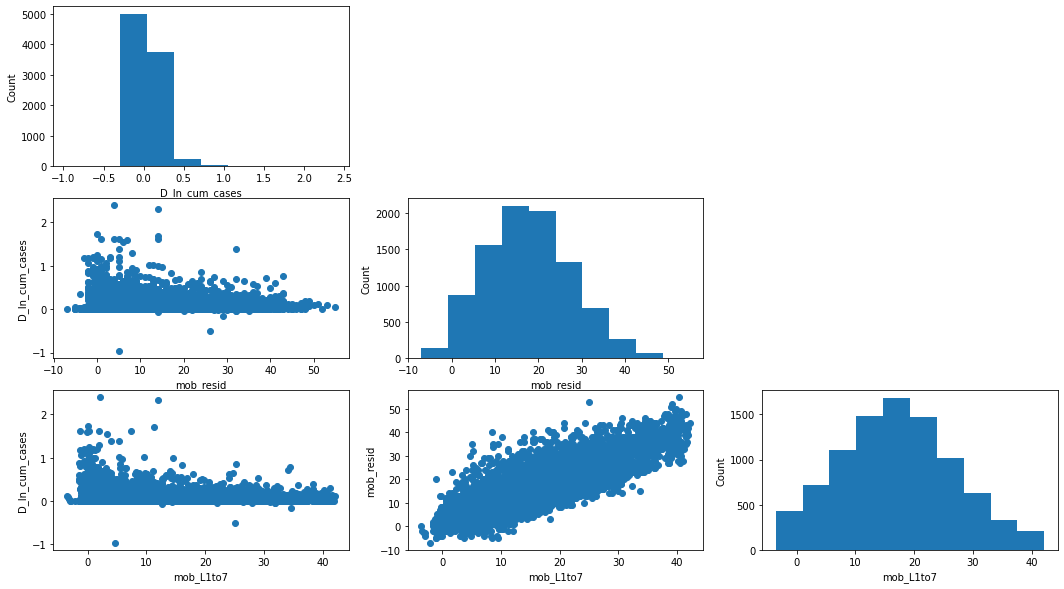

In [13]:
# for space/readability constraints let's just focus on the outcome and 2 features
features = ['D_ln_cum_cases', 'mob_resid','mob_L1to7']
scatterplotmatrix(df[features].values, names=features, figsize=(18,10), alpha=1);

We can see that an increase in residential mobility leads to a lower growth rate (hurray, the lockdown policy seems to be effective!?... well, we'll need to do some causal inference to conclude this, or test the predictions between the mobility and no_mobility models).

We can also see a positive correlation between the two mobility measures (this is expected).

The residential mobility variables seem to be normally distributed, but the growth rate is not.

Note that ML prediction does not require that the outcome and feature variables are normally distributed! This is a requirement for causal inference and hypothesis tests. 

Finally, the distribution of the mobility features does not vary, so there is no need to scale (standardize/normalize) them. 

Question: What's the difference between standardization and normalization?

#### Step 8.2: Correlation matrix of outcome and feature variables

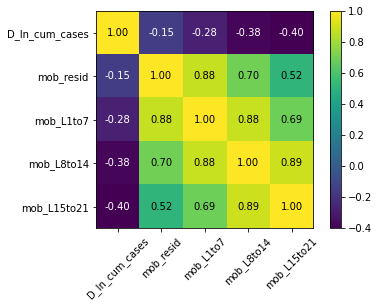

In [14]:
# let's add all mobility measures now
features = ['D_ln_cum_cases', 'mob_resid', 'mob_L1to7', 'mob_L8to14', 'mob_L15to21']
cm = df[features].corr().values
hm = heatmap(cm, row_names=features, column_names=features)

In general, we are interested in those features that have a high correlation with the target variable. 

We can see a relatively low correlation between mobility today (mob_resid) and the growth rate of Covid-19 cases. Is this surprising? Not really... it's very unlikely to see that an increase in residential mobility today affects the growth rate of cases today. Instead, looking at how changes in mobility 1,2,3 weeks ago, affects the growth rate today is more informative.

#### Step 8.3: Plot the relationship between mob_today and cum_cases

Note that I am plotting the raw data first, and then I draw (a) black vertical lines to show which data points are included after cleaning, and (b) grey vertical lines to show which data points are included in X_train and X_test.

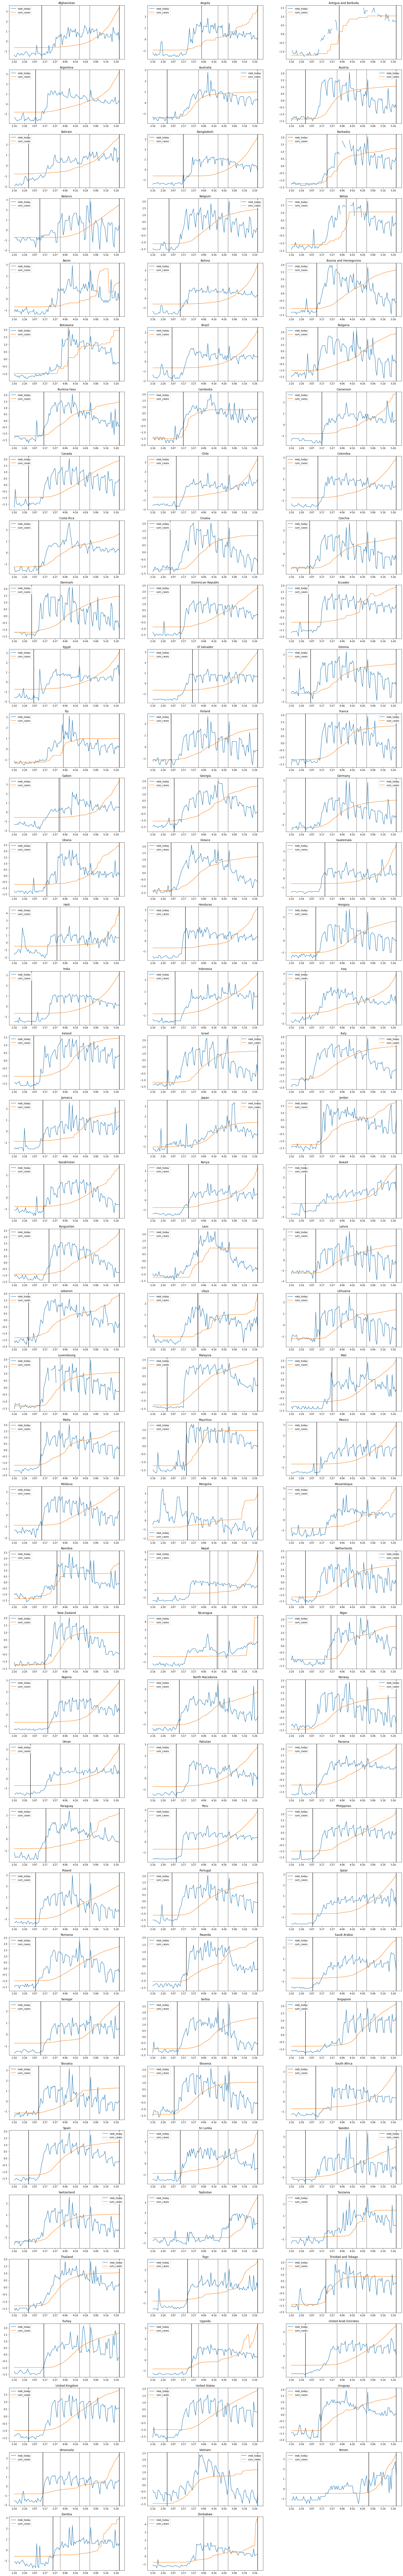

In [15]:
## define labels and countries of interest
x_labels = init_df.date.unique()
adm0 = df.adm0_name.unique()

## Initialize a new plot and set plot size
plt.figure(figsize=(30, 600)) 

for i in range(len(adm0)):
    # create sublots that are all on the same row
    ax = plt.subplot(len(adm0), 3, i+1)

    # subset data by adm    
    adm0_init_df= init_df[init_df.adm0_name == adm0[i]]

    # plot, but standardize mob_resid and cum_cases before ploting
    plt.plot(adm0_init_df.date, preprocessing.scale(adm0_init_df.mob_resid), label= 'mob_today');
    plt.plot(adm0_init_df.date, preprocessing.scale(adm0_init_df.cum_cases), label= 'cum_cases');
    
    
    # show the data used after cleaning (use black vertical lines)
    adm0_df = df[df.adm0_name == adm0[i]]
    plt.axvline(x=adm0_df.date.min(), color='black')
    plt.axvline(x=adm0_df.date.max(), color='black')
    
    # show the data used in X_train and X_test
    adm0_df_train = df_train[df_train.adm0_name == adm0[i]]
    adm0_df_test = df_test[df_test.adm0_name == adm0[i]]
    plt.axvline(x=adm0_df_train.date.min(),color='grey')
    plt.axvline(x=adm0_df_train.date.max(), color='grey')
    plt.axvline(x=adm0_df_test.date.max(), color='grey')
    
    
    #title, labels
    plt.legend(loc="best")
    plt.title(adm0[i])
    plt.xticks(x_labels[::10]) 


---
### Step 9: Analysis - linear regression (OLS)
---

Linear regression == obtain the best-fitting straight line through the examples in the training data.

There are two ways we can fit the training data:
 - using a closed-form solution: $(X'X)^{-1}(X'y)$
 - using an iterative solution: gradient descent (stochastic, batch, etc.)

#### Step 8.1 Fit and predict using a closed-form solution 

#### model fit 

(today we will be using the statsmodels library instead of scikit-learn)

In [16]:
# mobility
model = sm.OLS(y_train, X_train).fit() 
print(model.summary())

# no_mobility
model_nmob = sm.OLS(y_train_nmob, X_train_nmob).fit()
#print(model_nmob.summary())

                            OLS Regression Results                            
Dep. Variable:         D_ln_cum_cases   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     6.891
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           3.77e-88
Time:                        15:11:45   Log-Likelihood:                 3088.9
No. Observations:                2263   AIC:                            -5928.
Df Residuals:                    2138   BIC:                            -5212.
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
mob_L1to7                 -0

In [26]:
pd.DataFrame(model.params)*(X_train_nmob)

,0
mob_L1to7,-0.000659
mob_L8to14,-0.000509
mob_L15to21,-0.002241
Afghanistan,0.110387
Angola,0.128919
...,...
2,0.008954
3,0.006808
4,0.003507
5,-0.003905


#### model prediction

In [17]:
# mobibiltiy
y_hat = model.predict(X_test)

# no_mobility
y_hat_nmob = model_nmob.predict(X_test_nmob)

pd.DataFrame(y_hat).head()

,0
65,0.069981
66,0.079985
67,0.077160
68,0.072935
69,0.063639


Because this is a growth model, we need to take an extra step to compute predictions:

$predicted\_cum\_cases_{t+1}= exp(y\_hat_{t+1}) \times cum\_cases_{t}$ (implemented in the helper function below)

Hint: solve for $cum\_cases_{t+1}$ by applying the exponent on both sides growth_rate function above.

In [18]:
def helper(grp):
    ''' This function will normaly go on top of the file but let's keep it here so we can see clearly
    what's going on
    '''
    grp['pred_cum_cases'] = grp.cum_cases.shift(1)*grp.exp_yhat_te
    return grp

In [19]:
# add y_hat to df_test
df_test['yhat'] = pd.DataFrame(y_hat, columns = ['yhat'])
df_test_nmob['yhat'] = pd.DataFrame(y_hat_nmob, columns = ['yhat'])
    
# add exp_y_hat_te to df_test
df_test['exp_yhat_te'] = np.exp(df_test.yhat);
df_test_nmob['exp_yhat_te'] = np.exp(df_test_nmob.yhat)

# we are now ready to find find predicted cum_cases
pred = df_test.groupby(['adm0_name']).apply(helper);
pred_nmob = df_test_nmob.groupby(['adm0_name']).apply(helper)


# compute percentage error (for each date/country combination); useful to analyze model performance
pred['pct_error'] = ((pred.pred_cum_cases - pred.cum_cases)/pred.cum_cases)*100
pred_nmob['pct_error'] = ((pred_nmob.pred_cum_cases - pred_nmob.cum_cases)/pred_nmob.cum_cases)*100


# add a column to indicate the type of mobility model
pred['mob_model'] = 'mobility'
pred_nmob['mob_model'] = 'no_mobility'

# concatenate predictions from mob and no_mob models
pred_comb = pd.concat((pred, pred_nmob), sort=True)

# keep only columns of interest (easier for visualization)
pred_comb = pred_comb[['date', 'adm0_name', 'cum_cases', 'exp_yhat_te', 'pred_cum_cases', 'mob_model', 'pct_error']]
pred_comb.head(30)

,date,adm0_name,cum_cases,exp_yhat_te,pred_cum_cases,mob_model,pct_error
65,4-21,Afghanistan,1092,1.072487,NaN,mobility,NaN
66,4-22,Afghanistan,1176,1.083271,1182.931862,mobility,0.589444
67,4-23,Afghanistan,1279,1.080215,1270.333175,mobility,-0.677625
68,4-24,Afghanistan,1351,1.075660,1375.769261,mobility,1.833402
69,4-25,Afghanistan,1463,1.065707,1439.770450,mobility,-1.587802
70,4-26,Afghanistan,1531,1.065485,1558.805002,mobility,1.816133
71,4-27,Afghanistan,1703,1.066306,1632.514506,mobility,-4.138902
72,4-28,Afghanistan,1828,1.064613,1813.036392,mobility,-0.818578
73,4-29,Afghanistan,1939,1.073007,1961.456500,mobility,1.158149
74,4-30,Afghanistan,2171,1.070637,2075.965928,mobility,-4.377433


#### compute mean square error (MSE)

In [20]:
print('MSE test mobility model:', np.mean(np.sqrt(pred.pred_cum_cases - pred.cum_cases)))
print('MSE test no_mobility model:', np.mean(np.sqrt(pred_nmob.pred_cum_cases - pred_nmob.cum_cases)))

MSE test mobility model: 16.81663310286597
MSE test no_mobility model: 17.726785204067447


The mobility model seems to do slightly better. But I guess we expected to see a bigger improvement with the mobility model?

#### boxplot visualizations of the percentage error

(for each date/country combination)

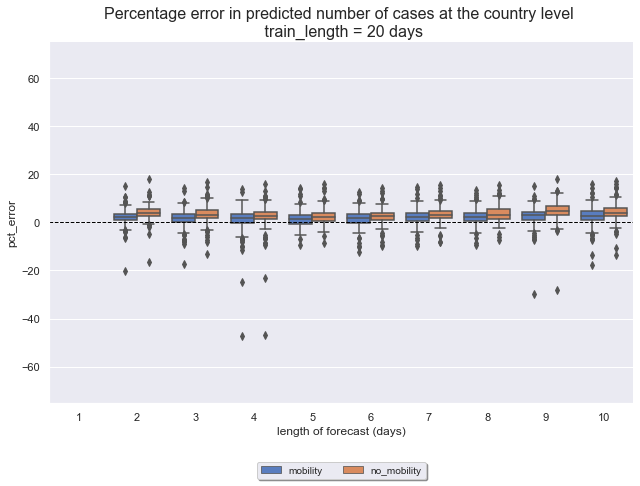

In [21]:
pct_error_plot(pred_comb, 'box')

#### investigate outliers

In [22]:
pred_comb.pct_error.describe()

count    2088.000000
mean        2.659941
std         4.459328
min       -47.309895
25%         1.051394
50%         2.714272
75%         4.552928
max        18.088544
Name: pct_error, dtype: float64

In [23]:
pred_comb[pred_comb.pct_error.le(-30)].adm0_name.unique()

array(['Ecuador'], dtype=object)

#### Step 8.2 Fit and predict using an iterative solution

We will do this next time. The idea is that closed-form solutions find the optimal solution analytically, which is a good thing, but:
- if working with very large data sets, inveting the X'X matrix can be computationally very expensive.
- the X'X may be singular (not-invertible); this happens when two or more features are co-linear.
- it cannot be used for regularization
- the linear model has a closed-form solution, but most other ML objectives don't have this luxury.

Iterative solutions (e.g. gradient descent) overcome all these issues.

### Step 9: Breakout room activity 

https://docs.google.com/spreadsheets/d/1joMfe_1RrQJ8j-GK85KOAdNlqtPwXmX-KV_tkJ3-ZEU/edit#gid=495628648